# **Udacity Data Scientist Nanodegree** - CRISP-DM model
---

## **1. Business Understanding**

**Airbnb** is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities [[1]](https://en.wikipedia.org/wiki/Airbnb#Overview). Here, millions of hosts and travelers choose to advertise their space and book unique accommodations, anywhere in the world. In addition, Airbnb experience hosts share their passions and interests with travelers and locals alike [[2]](https://www.airbnb.com.br/help/article/2503/o-que-é-o-airbnb-e-como-ele-funciona).


Made available by [Kaggle](https://www.kaggle.com/airbnb/boston), we're going to venture into Boston Airbnb dataset and try to answer the questions that the data points to us.

1. *When do people usually visit Boston?*
2. *Who are the users who rent on AirBnB?*
3. *Which fields most influence rental prices?*
4. *Bonus: But after all, what do customers have to say?*

**How about you? What motivates you to discover new places?**

In [1]:
# data preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from calendar import month_abbr

# modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

# sentiment analysis
import nltk
import string
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Matplotlib parameters to standardize the charts
---

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['legend.handlelength'] = 2.0
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

## **2. Data Understanding & Preparation**

### Importing the data
---

In [3]:
calendar = pd.read_csv("boston/calendar.csv")
listings = pd.read_csv("boston/listings.csv", parse_dates=['first_review', 'host_since', 'last_review'])
reviews = pd.read_csv("boston/reviews.csv", parse_dates=['date'])

### Operating some changes
---

In [4]:
# calendar
calendar['price'] = calendar.price.replace('[\$,]', '', regex=True).astype(float) # set price as float
calendar['day'] = pd.DatetimeIndex(calendar['date']).day # get date day
calendar['month'] = pd.DatetimeIndex(calendar['date']).month # get date month
calendar['year'] = pd.DatetimeIndex(calendar['date']).year # get date year
calendar['month_str'] = calendar['month'].apply(lambda month: month_abbr[month]) # using library to transform numeric month into string (1->Jan, 2->Feb, ..., 12->Dec)
calendar.dropna(subset=['price'], axis=0, inplace=True)

# listings
listings['price'] = listings.price.replace('[\$,]', '', regex=True).astype(float) # transform string prices into numeric
listings['host_since_year'] = pd.DatetimeIndex(listings['host_since']).year # get date year
listings['review_scores_value'].fillna(listings['review_scores_value'].mean(), inplace=True) # imputation method

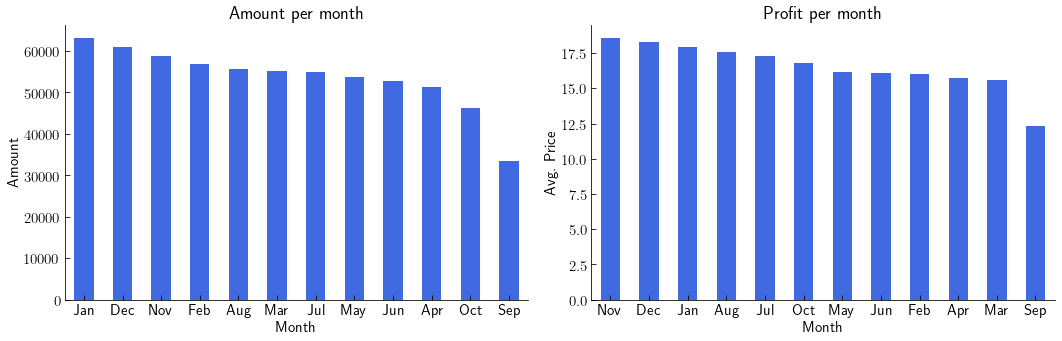

In [5]:
plt.figure(figsize=(15,5))

plt.subplot(121)
ax = calendar.month_str.value_counts().plot(kind='bar', color='royalblue', ylabel='Amount', xlabel='Month', title="Amount per month", rot=0)
plt.savefig("images/amount_per_year")

plt.subplot(122)
(calendar.groupby(['month_str'])['price'].sum() / (calendar.shape[0] - calendar.price.isnull().sum())).sort_values(ascending=False).plot(kind="bar", color='royalblue', ylabel="Avg. Price", xlabel='Month', title="Profit per month", rot=0);
plt.savefig("images/profit_per_year")

plt.tight_layout()

## **What time do people usually visit Boston?**
---
   According to the [U.S. News website](https://travel.usnews.com/Boston_MA/When_To_Visit/), the best time to visit Boston is from June to October due to the more pleasant weather provided by autumn. It is, therefore, the most expensive time to visit due to the number of tourists who come to the place for events that take place in that period.
<br>
   The data, however, present another perspective. <b>Graph 1</b> shows that the largest number of rents was made in the months of January, December, and November, which were also the most profitable months when analyzing <b>Graph 2</b>. These months, according to the [Santorini Dave website](https://santorinidave.com/best-time-to-visit-boston) has fewer visitors due to cold weather, making prices lower, confirming the peaks on the charts.

In [6]:
def low_high_price(listings_price: list) -> str:
    '''
    function to facilitate the analysis of prices above and below the average of a DataFrame
    
    Args:
        - listings_price: list -> the price column of listings
    
    Return: character according to the condition
    '''
    return 'H' if listings_price < price_mean else 'L'

In [7]:
# dataframe dataframe only from reviews
reviews_df = listings[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]
fill_mean = lambda col: col.fillna(col.mode()) # mode function

reviews_df = reviews_df.apply(fill_mean, axis=1) # applying mode function to the reviews

reviews_df['price'] = listings.price
price_mean = reviews_df['price'].mean() # mean of price

reviews_df['price'] = reviews_df['price'].apply(low_high_price) # applying low_high_price to new reviews price
H = reviews_df[reviews_df['price'] == 'H'].drop('price', axis=1) # prices above average
L = reviews_df[reviews_df['price'] == 'L'].drop('price', axis=1) # prices below average

# synthesize reviews in just one column
H = H.apply(lambda col: col.mean(), axis=0)
L = L.apply(lambda col: col.mean(), axis=0)

# calculate the percentage of each value
H_perc = H/H.sum()
L_perc = L/L.sum()

In [8]:
difference_perc_df = pd.concat([H_perc, L_perc], axis=1) # concat low & high prices in one dataframe
difference_perc_df.rename(columns={0:'H', 1:'L'}, inplace=True)
difference_perc_df.index = [index.replace('review_scores_', '').capitalize() for index in difference_perc_df.index] # change indexes name

difference_perc_df['Diff_H_L'] = difference_perc_df['H'] - difference_perc_df['L'] # calculate difference between percentages
difference_perc_df.style.bar(subset=['Diff_H_L'], align='mid', color=['#F7DBA7', '#9CAFB7']) # show in dataframe bar chart

,H,L,Diff_H_L
Accuracy,0.167085,0.166206,0.000878
Cleanliness,0.162223,0.165922,-0.003699
Checkin,0.171552,0.168963,0.002589
Communication,0.171472,0.169099,0.002372
Location,0.164912,0.168784,-0.003872
Value,0.162757,0.161026,0.001731


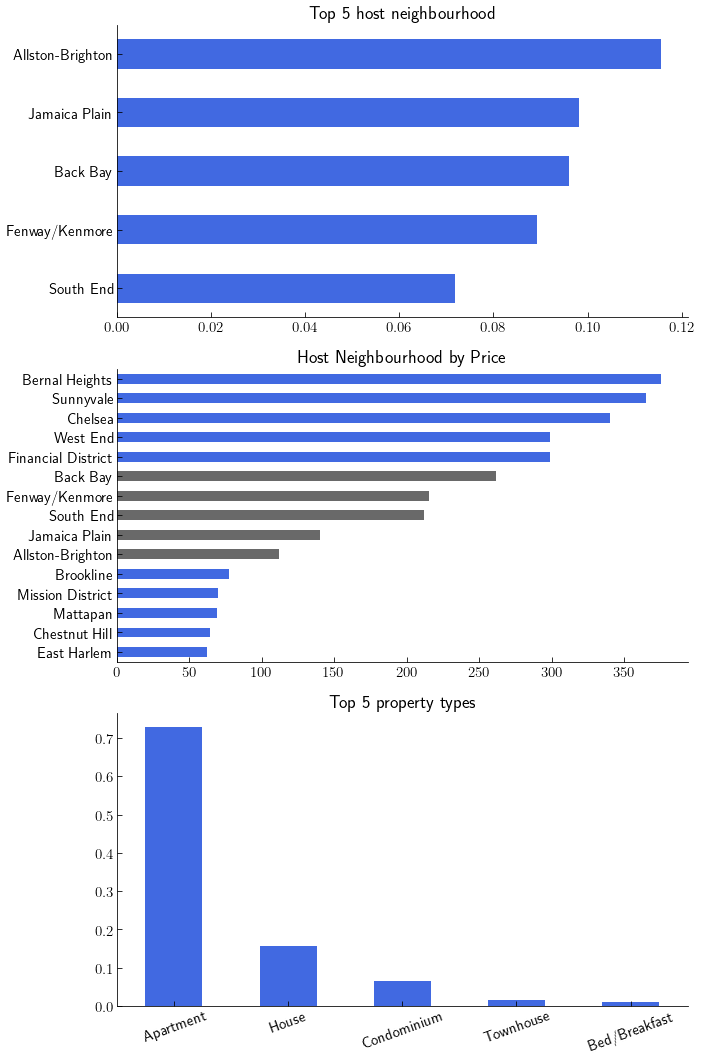

In [9]:
plt.figure(figsize=(10,15))

plt.subplot(311) # top 5 neighbourhood
percent_host_neighb = listings.host_neighbourhood.value_counts() / (listings.shape[0] - listings.host_neighbourhood.isnull().sum()) # get host neighbourhood percent
top_5_host_neighb = percent_host_neighb.head(5).sort_values(ascending=True) # get top 5
top_5_host_neighb.plot(kind="barh", color='royalblue', title="Top 5 host neighbourhood");
plt.savefig("images/top_5_neighbourhood")


plt.subplot(312) # compare high and low neighbourhood prices with top 5 neighbourhood
prices_per_neighbourhood = listings.groupby(['host_neighbourhood'])['price'].mean().sort_values(ascending=False)
all_together = pd.concat([prices_per_neighbourhood.head(), prices_per_neighbourhood.tail(), prices_per_neighbourhood[top_5_host_neighb.keys()]], axis=0).sort_values(ascending=True)

colors_list = ['dimgray' if name in top_5_host_neighb.keys() else 'royalblue' for name in all_together.keys()] # separate high & low prices from top 5 neighbourhood
all_together.sort_values(ascending=True).plot(kind='barh', color=colors_list, title='Host Neighbourhood by Price');
plt.savefig("images/host_neighbourhood_by_price")


plt.subplot(313) # compare property types
percent_prop_type = listings.property_type.value_counts() / listings.shape[0]
percent_prop_type.index = ['Apartment', 'House', 'Condominium', 'Townhouse', 'Bed/Breakfast', 'Loft', 'Other', 'Boat', 'Villa', 'Entire Floor', 'Dorm', 'Camper/RV', 'Guesthouse']
percent_prop_type.head(5).plot(kind="bar", title="Top 5 property types", color='royalblue', rot=20);
plt.savefig("images/top_5_property_types")

plt.tight_layout()

In [10]:
listings_interest_columns = ['id', 'neighbourhood', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
reviews_interest_columns = ['listing_id', 'comments']

listings_neighb_reviews = listings[listings_interest_columns] # new listings df with only listings_interest_columns
reviews_comments = reviews[reviews_interest_columns] # # new reviews df with only listings_interest_columns
reviews_comments.columns = ['id', 'comments']

listings_reviews = listings_neighb_reviews.merge(reviews_comments, on="id", how="right") # merge the new listings and new reviews on id

In [11]:
numeric_listings = listings_reviews.select_dtypes(include=['float', 'int']).columns # numerical variables
listings_reviews[numeric_listings] = listings_reviews[numeric_listings].apply(fill_mean, axis=1) # mean imputation
listings_reviews.dropna(subset=['neighbourhood'], axis=0, inplace=True) # removing rows with NaN values from new merged df

In [12]:
reviews_gt_70 = pd.DataFrame(listings_reviews.query("review_scores_rating >= 70.0"))['neighbourhood'].value_counts() # greater/equals than mean (>= 70.0) per neighbourhood
reviews_lt_70 = pd.DataFrame(listings_reviews.query("review_scores_rating < 70.0"))['neighbourhood'].value_counts() # lower than mean (< 70.0) per neighbourhood

reviews_overview = pd.concat([reviews_gt_70, reviews_lt_70], axis=1).dropna() # concat the reviews
reviews_overview.columns = ["Greater Than 70", "Lower Than 70"]
reviews_overview.sort_values(by=["Greater Than 70", "Lower Than 70"], ascending=False)

,Greater Than 70,Lower Than 70
Jamaica Plain,8639,2.0
Dorchester,6407,46.0
South End,5137,8.0
Allston-Brighton,5099,45.0
East Boston,4621,13.0
Back Bay,4360,11.0
South Boston,4250,2.0
North End,4093,5.0
Beacon Hill,3479,14.0
Roxbury,3234,1.0


<Figure size 720x1080 with 0 Axes>

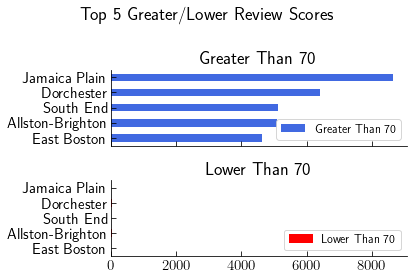

In [13]:
plt.figure(figsize=(10,15))
plt.rcParams['legend.fontsize'] = 12

reviews_overview.head().sort_values(by=["Greater Than 70"], ascending=True).plot(kind="barh", color=['royalblue', "red"], subplots=True, title="Top 5 Greater/Lower Review Scores");
plt.tight_layout()
plt.savefig("images/top_5_greater_lower_review_scores")
plt.legend(loc="lower right");

## **Who are the users who rent on AirBnB?**

The search for apartments is also a strong point, with more than 70% of searches, according to <b>Graph 4</b>. <b>Graph 3</b> shows the 5 most searched neighborhoods by visitors, which, when compared to <b>Graph 5</b>, shows that most visitors search average prices. <b>Figure 1</b> gives an overview of the difference in review scores between above and below average neighborhood prices. The biggest differentials of neighborhoods with prices above the average are the <i>cleanliness</i> and <i>location</i>.
<br><br>
It is also worth analyzing that, among the ratings, Jamaica Plain (the most sought after neighborhood) has the highest number of ratings higher than the average (considering an average of 7.0). The neighborhoods of South End, Allston-Brighton and East Boston also appear in the list, being the preferred ones for being at the top of the searches and with the highest amount of positive reviews.
On the other hand, Allston-Brighton ranks first in the number of ratings below average, however, the difference between the number of positive and negative ratings is quite high (5081 positive to 56 negative)

## **3. Modeling**

In [14]:
# columns used to predict price
important_columns = ['neighbourhood', 'property_type',
    'room_type', 'accommodates', 'bathrooms', 'host_since',
    'bedrooms', 'beds', 'price', 'guests_included']

cleaned_listings = listings[important_columns].copy()
cleaned_listings['host_since'] = pd.DatetimeIndex(cleaned_listings['host_since']).year # only year from host_since

In [15]:
# imputating mean on the numeric variables
df_numerical_columns = cleaned_listings.select_dtypes(include=['int', 'float']).columns
fill_mean = lambda col: col.fillna(col.mean())
cleaned_listings[df_numerical_columns] = cleaned_listings[df_numerical_columns].apply(fill_mean, axis=0)

In [16]:
# dummy categorical variables
df_categorical_columns = cleaned_listings.select_dtypes(include=['object']).columns
for variable in df_categorical_columns:
    cleaned_listings = pd.concat([cleaned_listings.drop(variable, axis=1), pd.get_dummies(cleaned_listings[variable], prefix=variable, prefix_sep='_', dummy_na=True, drop_first=True)], axis=1)

In [17]:
X = cleaned_listings.drop(['price'], axis=1) # x features from train
y = cleaned_listings['price'] # the feature we have to predict

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2513) # the random_state was choosen by test
X_train.shape, y_train.shape, X_test.shape, y_test.shape # checking the shapes - how many data goes to learning

((2509, 52), (2509,), (1076, 52), (1076,))

In [18]:
lm_model = LinearRegression(normalize=True) # instantiate the Linear Regression module
lm_model.fit(X_train, y_train) #fit

# predict the model for test and train
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

# calculate the r-squared
rsquared_score_test = r2_score(y_test, y_test_preds)
rsquared_score_train = r2_score(y_train, y_train_preds)
ms_error = mean_squared_error(y_test, y_test_preds) # calculate mean squared error
length_y_test = len(y_test)
length_y_train = len(y_train)

print('mean squared error: %.2f' % ms_error)
print("r-squared score for test model was {} on {} values.".format(rsquared_score_test, length_y_test))
print("r-squared score for train model was {} on {} values.".format(rsquared_score_train, length_y_train))

mean squared error: 5108.26
r-squared score for test model was 0.5669556105555928 on 1076 values.
r-squared score for train model was 0.2905793764881407 on 2509 values.


In [19]:
pca = PCA(n_components=1) # instatiating PCA to change the shape of the X_test to fit the scatter plot
X_test = pca.fit_transform(X_test)

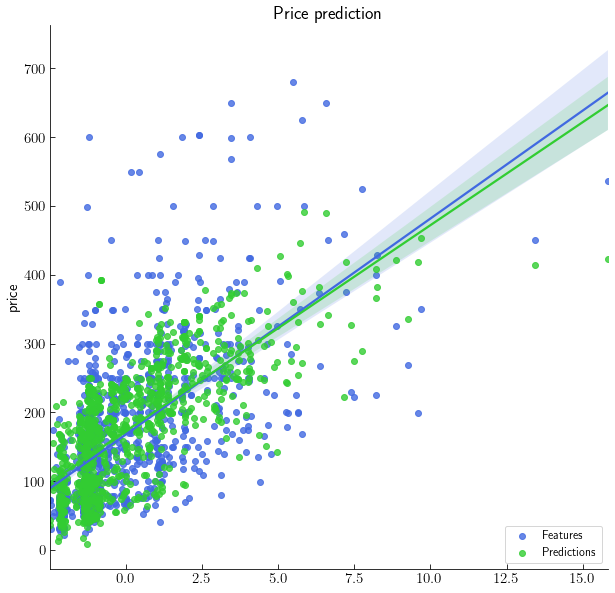

In [20]:
# visualize the data 
plt.figure(figsize=(10,10))

sns.regplot(x=X_test, y=y_test, color='royalblue', label='Features')
sns.regplot(x=X_test, y=y_test_preds, color='limegreen', label='Predictions')
plt.title("Price prediction")
plt.savefig("images/price_prediction")
plt.legend(loc='lower right');

In [21]:
# based on Udacity lessons
def coef_weights(coefficients, X_train):
    '''
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    
    Args:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    
    Returns:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [23]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(15).style.bar(subset=['abs_coefs'], align='mid', color="#F7DBA7")

,est_int,coefs,abs_coefs
20,neighbourhood_Harvard Square,-177.490863,177.490863
15,neighbourhood_Downtown Crossing,114.157138,114.157138
18,neighbourhood_Financial District,111.947424,111.947424
17,neighbourhood_Fenway/Kenmore,100.678897,100.678897
6,neighbourhood_Back Bay,93.764680,93.764680
23,neighbourhood_Leather District,93.036452,93.036452
32,neighbourhood_Theater District,82.770913,82.770913
7,neighbourhood_Beacon Hill,79.942061,79.942061
30,neighbourhood_South Boston,79.156056,79.156056
45,property_type_Other,79.002505,79.002505


In [24]:
price_impact = coef_df.est_int.str.split('_').apply(lambda label: label[0]).value_counts()
price_impact.name = 'Price Impact'
price_impact_perc = price_impact/price_impact.sum() * 100
price_impact_perc

neighbourhood    57.692308
property         25.000000
room              5.769231
guests            1.923077
host              1.923077
accommodates      1.923077
bedrooms          1.923077
beds              1.923077
bathrooms         1.923077
Name: Price Impact, dtype: float64

## **Which fields most influence rental prices?**

Would you be able to predict the price of accommodation based only on the *neighborhood*, *type of property*, *type of room*, *number of rooms*, *bathrooms* and *beds*, and how long the host is on business? And what influence do these fields have on price? 30% of the values ​​were separated for tests and the **Price prediction** regression graph shows the comparison of the actual values ​​with the prediction. The values ​​do not fully match, but the trend lines slope closely together, supporting a prediction closer to the true value. From the table presented, we can also see that the *neighborhood* is the field that most influences the price, followed by the type of *property* and *room*.

In [25]:
listings_reviews['comments'].fillna('', inplace=True) # replace NaN values to use NLTK to predict the sentiment analysis

In [26]:
def get_sentiment_score(comment: str):
    '''
    Function returns the percentage of feeling (negative, neutral and positive) of a comment based on the SentimentIntensityAnalyzer from the NLTK library
    
    Args:
        - comment: str -> comments to be analyzed
    
    Returns: the percentage of feeling (negative, neutral and positive) in a dictionary or N/A for null comments
    '''
    if comment != '':
        s_analyser = SentimentIntensityAnalyzer()
        return s_analyser.polarity_scores(comment)
    else:
        return 'N/A'

In [27]:
def get_reviews(comments: list, review_type: str) -> list:
    '''
    For each element in the processed list of words, separate those that have a positive or negative content, based on the function argument.
    
    Args:
        - comments: list -> list of words
        - review_type -> kind of feeling desired ('pos': positive comments, 'neg': negative comments)
    
    Returns: list with only comments with review_type category
    '''
    values = []
    s_analyser = SentimentIntensityAnalyzer()
    for word in comments:
        result = s_analyser.polarity_scores(word)
        if result[review_type] > 0.4:
            values.append(word)

    return values

In [28]:
# based on https://youtu.be/Ns2Adgcd3yE
def process_data(text: str) -> list:
    '''
    clears unnecessary elements for evaluating the sentiment percentage in the text, such as punctuation and stopwords
    
    Args:
        - text: str -> text to be analysed
    
    Returns: list of all lowercase and processed words
    '''
    no_punctuation = [letter for letter in text if letter not in string.punctuation] # eliminate punctuation
    no_punctuation = ''.join(no_punctuation) # turn into single string again without punctuation
    
    return [word.lower() for word in no_punctuation.split() if word.lower() not in stopwords.words("english")]

In [29]:
# listings_reviews['clean_text'] = listings_reviews['comments'].apply(process_data) # clean the comments
# listings_reviews['positive'] = listings_reviews['clean_text'].apply(lambda row: get_reviews(row, 'pos')) # only positive comments based on nltk SentimentIntensityAnalyzer
# listings_reviews['negative'] = listings_reviews['clean_text'].apply(lambda row: get_reviews(row, 'neg')) # only negative comments based on nltk SentimentIntensityAnalyzer

# the above procedure may take some time to process. If you want to avoid this, use the dataset below (data already processed)
listings_reviews = pd.read_csv("listings_reviews.csv", usecols=["positive", "negative"])
# lambda function: https://stackoverflow.com/questions/32742976/how-to-read-a-column-of-csv-as-dtype-list-using-pandas
correct_formatting = lambda label: label.strip("[]").replace("'","").split(", ") # string -> list
listings_reviews['positive'] = listings_reviews['positive'].apply(correct_formatting)
listings_reviews['negative'] = listings_reviews['negative'].apply(correct_formatting)

In [30]:
listings_reviews[['positive', 'negative']]

,positive,negative
0,"[cool, good, nice, clean, pretty, well]",[]
1,"[great, great, helpful]",[]
2,"[enjoyed, inviting, nice, prepared, share, fin...",[problem]
3,"[nice, clean, safe, helpful, recommend]",[]
4,"[great, good, clean]",[]
...,...,...
60766,"[perfect, easy, excellently, recommended]",[]
60767,"[great, recommend, perfect]",[]
60768,"[enjoyed, great, easy, reach, pleasant, beauti...",[]
60769,"[jewel, hope, easy, fantastic, enjoy, definite...",[]


In [31]:
positives = []
for label in listings_reviews['positive']: # gather only posivite comments
    if label != ['']:
        positives.extend(label)
    
negatives = []
for label in listings_reviews['negative']: # gather only negative comments
    if label != ['']:
        negatives.extend(label)
    
frequency_positives = FreqDist(positives) # frequency of each positive word
frequency_negatives = FreqDist(negatives) # frequency of each negative word

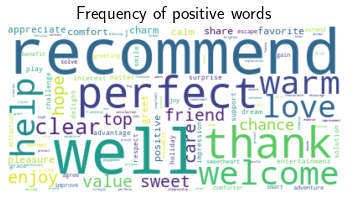

In [32]:
wc_positive = WordCloud(background_color='white').generate(' '.join(frequency_positives))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Frequency of positive words")
plt.savefig("images/positive_wordcloud")
plt.axis("off")
plt.show()

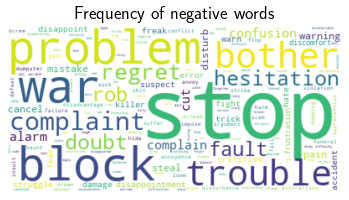

In [33]:
wc_negative = WordCloud(background_color='white').generate(' '.join(frequency_negatives))
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Frequency of negative words")
plt.savefig("images/negative_wordcloud")
plt.axis("off")
plt.show()

## **Bonus: but after all, what do customers have to say?**

The analysis through customer ratings was not very effective as the comments sometimes did not correspond with the review scores given. That's why it was necessary to comb through each comment and evaluate the positive and negative feelings they expressed. Fortunately the positive results corresponded to most of the comments made and words like *'perfect'*, *'warm'*, *'clear'*, *'care'* and *'love'*, for example, can be seen in the figure **Frequency of positive words**, but it hasn' t all been good. In **Frequency of negative words** we can observe words like *'problem'*, *'bother'*, *'trouble'*, or even worse like *'rob'*, *'cut'* and *'pain'*. So find out more about where you will be staying to avoid frustrating experiences.